In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.8/381.8 kB 14.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import timm

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the pre-trained ConvNeXt model
convnext_model = timm.create_model('convnext_base', pretrained=True, num_classes=0)  # num_classes=0 removes the top layer

# Build the new model by adding custom classification layers
inputs = Input(shape=(128, 128, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs)  # Preprocess the input
x = convnext_model(x, training=False)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Function to get intermediate layer models
def get_activation_model(model, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    return activation_model

# Create activation model
layer_names = ['convnext_base_stem', 'convnext_base_stages_0_0', 'convnext_base_stages_1_0']  # Replace with actual ConvNeXt layer names
activation_model = get_activation_model(model, layer_names)

# Choose a sample image from the test set
sample_image = X_test[0].reshape(1, 128, 128, 3)  # Reshape to match model input shape

# Get intermediate activations
activations = activation_model.predict(sample_image)

# Visualize the activations
fig, ax = plt.subplots(len(layer_names), 8, figsize=(20, 20))
for layer_index, activation in enumerate(activations):
    num_channels = activation.shape[-1]
    for channel_index in range(8):  # Plot the first 8 channels for simplicity
        ax[layer_index, channel_index].imshow(activation[0, :, :, channel_index], cmap='viridis')
        ax[layer_index, channel_index].axis('off')
        
plt.show()

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

TypeError: ConvNeXt.forward() got an unexpected keyword argument 'training'

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
import timm

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom Keras Layer to use timm's ConvNeXt model
class TimmConvNeXt(tf.keras.layers.Layer):
    def __init__(self, model_name: str, pretrained: bool):
        super(TimmConvNeXt, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0)

    def call(self, inputs):
        return self.model(inputs)

# Build the new model by adding custom classification layers
inputs = Input(shape=(128, 128, 3))
x = TimmConvNeXt('convnext_base', pretrained=True)(inputs)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Function to get intermediate layer models (Note: ConvNeXt uses different layer names)
def get_activation_model(model, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    return activation_model

# Create activation model
layer_names = ['timm_conv_ne_x_t', 'flatten', 'dense', 'dropout', 'dense_1']  # Update to actual names if needed
activation_model = get_activation_model(model, layer_names)

# Choose a sample image from the test set
sample_image = X_test[0].reshape(1, 128, 128, 3)  # Reshape to match model input shape

# Get intermediate activations
activations = activation_model.predict(sample_image)

# Visualize the activations
fig, ax = plt.subplots(len(layer_names), 8, figsize=(20, 20))
for layer_index, activation in enumerate(activations):
    num_channels = activation.shape[-1]
    for channel_index in range(8):  # Plot the first 8 channels for simplicity
        ax[layer_index, channel_index].imshow(activation[0, :, :, channel_index], cmap='viridis')
        ax[layer_index, channel_index].axis('off')
        
plt.show()

TypeError: Exception encountered when calling TimmConvNeXt.call().

[1mCould not automatically infer the output shape / dtype of 'timm_conv_ne_xt' (of type TimmConvNeXt). Either the `TimmConvNeXt.call()` method is incorrect, or you need to implement the `TimmConvNeXt.compute_output_spec() / compute_output_shape()` method. Error encountered:

conv2d() received an invalid combination of arguments - got (SymbolicTensor, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!SymbolicTensor!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!SymbolicTensor!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
[0m

Arguments received by TimmConvNeXt.call():
  • args=('<KerasTensor shape=(None, 128, 128, 3), dtype=float32, sparse=None, name=keras_tensor_6>',)
  • kwargs=<class 'inspect._empty'>

In [7]:
pip install tensorflow-hub

  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(128, 128))  # Resize images for consistency
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use TensorFlow Hub to load the ConvNeXt model
convnext_url = "https://tfhub.dev/google/imagenet/convnext_base/classification/feature_vector/1"
convnext_layer = hub.KerasLayer(convnext_url, trainable=True)

# Build the new model by adding custom classification layers
inputs = Input(shape=(128, 128, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs)  # Make sure inputs are normalized correctly
x = convnext_layer(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

# Function to get intermediate layer models
def get_activation_model(model, layer_names):
    outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=outputs)
    return activation_model

# Create activation model
layer_names = ['hub_keras_layer', 'flatten', 'dense', 'dropout', 'dense_1']  # Update to actual names
activation_model = get_activation_model(model, layer_names)

# Choose a sample image from the test set
sample_image = X_test[0].reshape(1, 128, 128, 3)  # Reshape to match model input shape

# Get intermediate activations
activations = activation_model.predict(sample_image)

# Visualize the activations
fig, ax = plt.subplots(len(layer_names), 8, figsize=(20, 20))
for layer_index, activation in enumerate(activations):
    num_channels = activation.shape[-1]
    for channel_index in range(8):  # Plot the first 8 channels for simplicity
        ax[layer_index, channel_index].imshow(activation[0, :, :, channel_index], cmap='viridis')
        ax[layer_index, channel_index].axis('off')
        
plt.show()

OSError: https://tfhub.dev/google/imagenet/convnext_base/classification/feature_vector/1 does not appear to be a valid module.

In [11]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

# CNN model for spectra classification
class SpectraCNN(nn.Module):
    def __init__(self):
        super(SpectraCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjusted input size based on your model's output
        self.fc2 = nn.Linear(128, 2)  # 2 classes: Deepfake, Original

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        
        # Automatically flatten based on input size
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No activation for the output layer (logits)
        return x

# Function to load a saved model
def load_model(model_path, device):
    model = SpectraCNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set the model to evaluation mode
    return model

# Function to predict class for a single image
def predict_image(model, image_path, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    return 'Original' if predicted.item() == 1 else 'Deepfake'

# Main function to load model and predict
def main():
    # Set up device (CPU or CUDA if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the trained model
    model_path = '/Users/atharvapore/Desktop/Masters/Sem_03/Thesis/activation_layer/spectra_cnn_model.pth'  # Path to your saved model
    model = load_model(model_path, device)
    
    # Set up the image transformation (resize and convert to tensor)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    
    # Path to the image you want to test
    image_path = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images/Barack_Obama_168.png'  # Update your image path here
    image_path_2 = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images/Barack_Obama_33.png'
    # Predict the image class
    prediction = predict_image(model, image_path_2, transform, device)
    print(f"The predicted class for the image is: {prediction}")

if __name__ == '__main__':
    main()


/var/folders/tc/p09j7ll56zbbhd266ds5wqh40000gn/T/ipykernel_61272/1915599399.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

FileNotFoundError: [Errno 2] No such file or directory: '/Users/atharvapore/Desktop/Masters/Sem_03/Thesis/activation_layer/spectra_cnn_model.pth'

Epoch [1/10], Loss: 0.5186, Accuracy: 77.29%
Epoch [2/10], Loss: 0.2255, Accuracy: 91.63%
Epoch [3/10], Loss: 0.0281, Accuracy: 99.20%
Epoch [4/10], Loss: 0.0078, Accuracy: 100.00%
Epoch [5/10], Loss: 0.0021, Accuracy: 100.00%
Epoch [6/10], Loss: 0.0060, Accuracy: 99.87%
Epoch [7/10], Loss: 0.0009, Accuracy: 100.00%
Epoch [8/10], Loss: 0.0011, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0001, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy: 100.00%


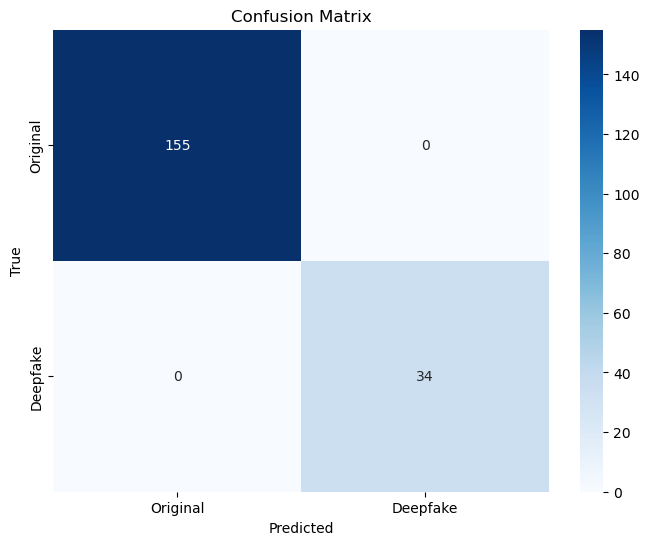

              precision    recall  f1-score   support

    Original       1.00      1.00      1.00       155
    Deepfake       1.00      1.00      1.00        34

    accuracy                           1.00       189
   macro avg       1.00      1.00      1.00       189
weighted avg       1.00      1.00      1.00       189



AttributeError: 'Conv2d' object has no attribute 'output'

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define the CNN model
class SpectraCNN(nn.Module):
    def __init__(self):
        super(SpectraCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Custom dataset class for loading images
class SpectrogramDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Function to load images and assign labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((128, 128))  # Resize images for consistency
            images.append(img)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images and labels
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
images = np.array(deepfake_images + original_images)
labels = np.array(deepfake_labels + original_labels)

# Convert labels to tensor
labels = torch.tensor(labels)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = SpectrogramDataset(train_images, train_labels, transform=transform)
test_dataset = SpectrogramDataset(test_images, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpectraCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# Evaluating the model
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plot training & validation accuracy values
# (For the simplicity of this example, we do not distinguish train/val split within train set and consider all training data)

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Original', 'Deepfake']))

# Function to get intermediate layer models (Note: ConvNeXt uses different layer names)
def get_activation_model(model, layer_names):
    outputs = [model._modules.get(layer_name).output for layer_name in layer_names]
    activation_model = nn.Sequential(*outputs)
    return activation_model

# Get sample image from the test set
sample_image = test_images[0]
sample_image = transform(sample_image).unsqueeze(0).to(device)

# Get intermediate activations
activation_model = get_activation_model(model, ['conv1', 'conv2', 'conv3'])
activations = activation_model(sample_image)

# Visualize the activations
fig, axes = plt.subplots(3, 8, figsize=(20, 20))
for layer_index, activation in enumerate(activations):
    num_channels = activation.shape[1]
    for channel_index in range(8):  # Visualize the first 8 channels
        ax = axes[layer_index, channel_index]
        ax.imshow(activation[0, channel_index].cpu().numpy(), cmap='viridis')
        ax.axis('off')

plt.show()

Epoch [1/10], Loss: 0.5511, Accuracy: 77.29%
Epoch [2/10], Loss: 0.3218, Accuracy: 84.06%
Epoch [3/10], Loss: 0.0636, Accuracy: 98.41%
Epoch [4/10], Loss: 0.0235, Accuracy: 99.47%
Epoch [5/10], Loss: 0.0057, Accuracy: 99.87%
Epoch [6/10], Loss: 0.0066, Accuracy: 99.87%
Epoch [7/10], Loss: 0.0006, Accuracy: 100.00%
Epoch [8/10], Loss: 0.0004, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0003, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0002, Accuracy: 100.00%
Test Accuracy: 100.00%


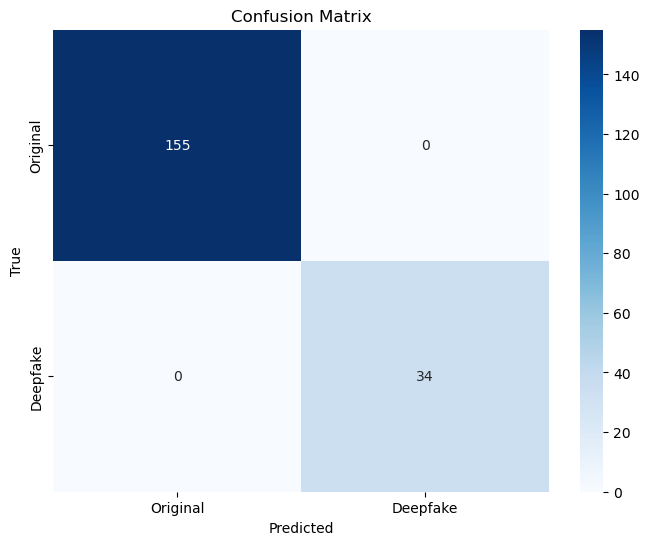

              precision    recall  f1-score   support

    Original       1.00      1.00      1.00       155
    Deepfake       1.00      1.00      1.00        34

    accuracy                           1.00       189
   macro avg       1.00      1.00      1.00       189
weighted avg       1.00      1.00      1.00       189



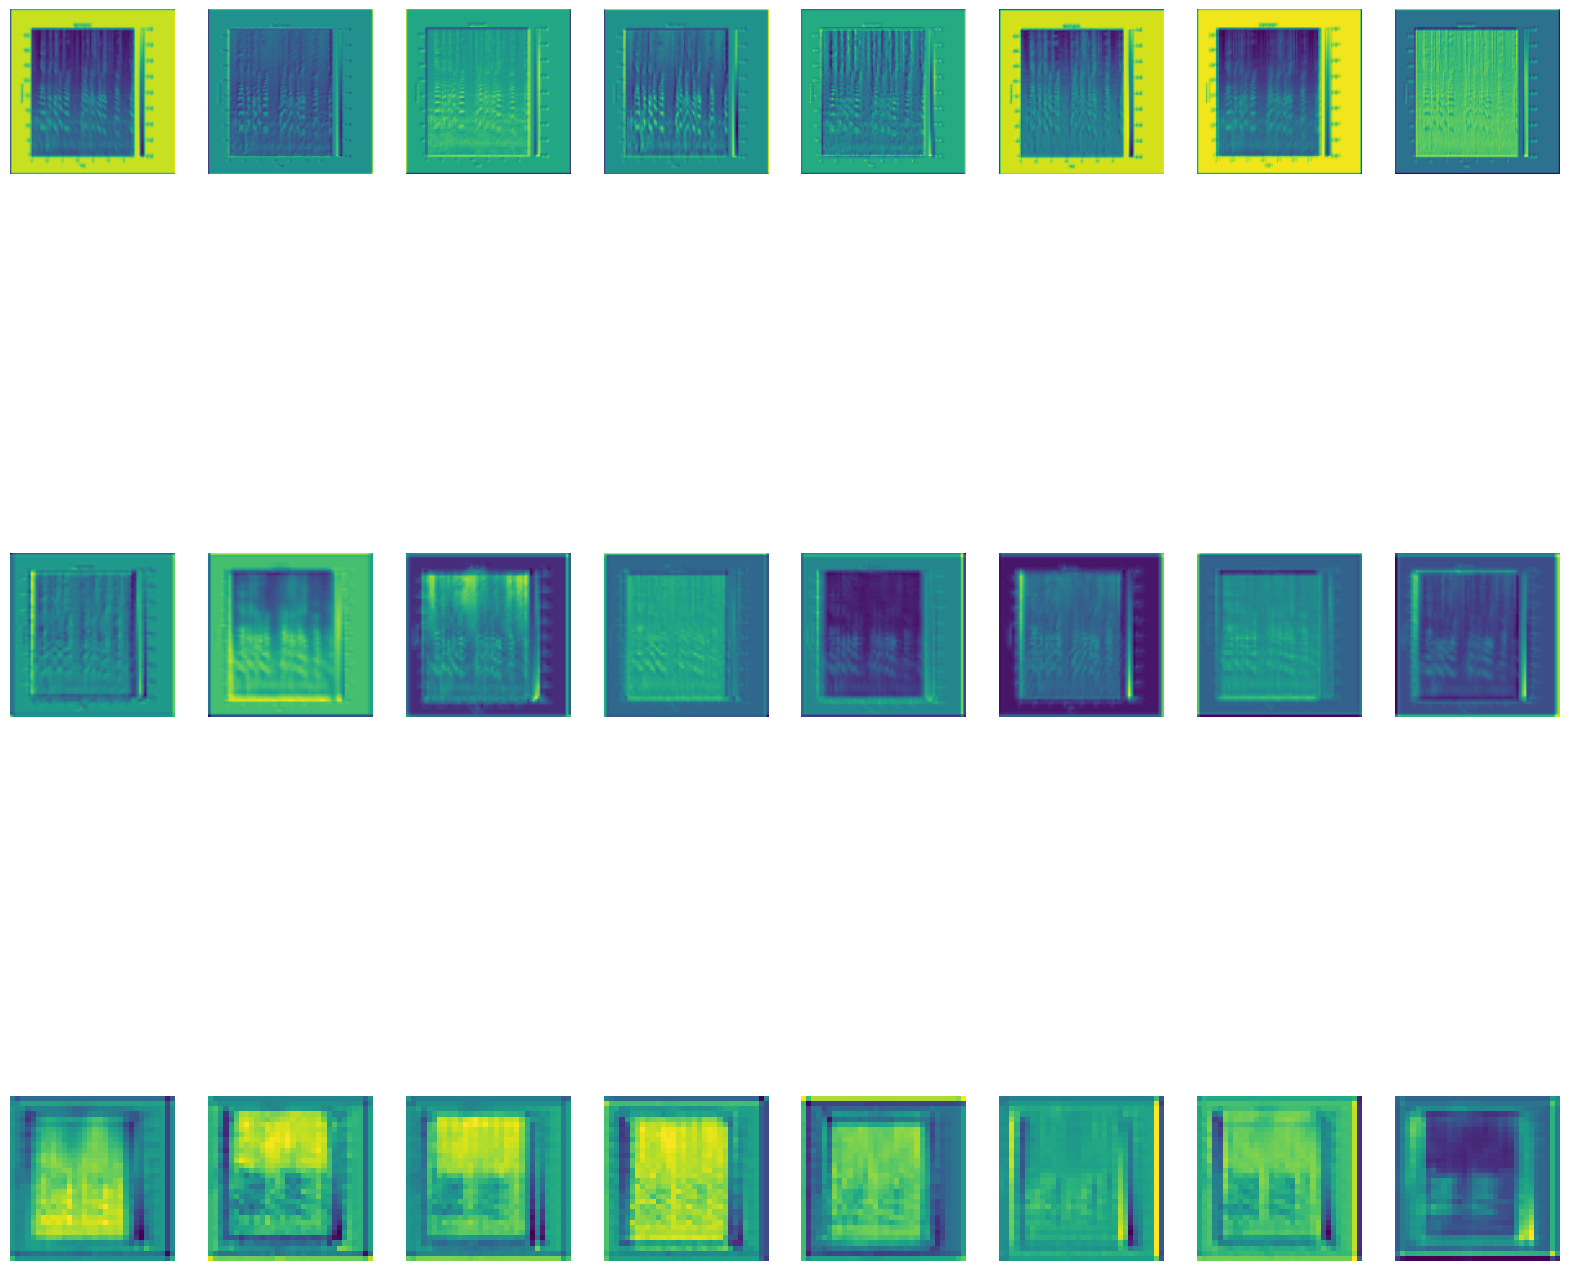

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define the CNN model
class SpectraCNN(nn.Module):
    def __init__(self):
        super(SpectraCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Custom dataset class for loading images
class SpectrogramDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Function to load images and assign labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((128, 128))  # Resize images for consistency
            images.append(img)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images and labels
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
images = np.array(deepfake_images + original_images)
labels = np.array(deepfake_labels + original_labels)

# Convert labels to tensor
labels = torch.tensor(labels)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = SpectrogramDataset(train_images, train_labels, transform=transform)
test_dataset = SpectrogramDataset(test_images, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpectraCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# Evaluating the model
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plot training & validation accuracy values
# (For the simplicity of this example, we do not distinguish train/val split within train set and consider all training data)

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Original', 'Deepfake']))

# Function to register hooks for intermediate layers
def register_hooks(model, layer_names):
    activations = {}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    hooks = []
    for name in layer_names:
        layer = model._modules.get(name)
        if layer is not None:
            hooks.append(layer.register_forward_hook(get_activation(name)))
    return activations, hooks

# Get sample image from the test set
sample_image = test_images[0]
sample_image = transform(sample_image).unsqueeze(0).to(device)

# Register hooks to capture activations
activations, hooks = register_hooks(model, ['conv1', 'conv2', 'conv3'])

# Pass the sample image through the model to capture activations
model.eval()
with torch.no_grad():
    _ = model(sample_image)

# Remove hooks
for hook in hooks:
    hook.remove()

# Visualize the activations
fig, axes = plt.subplots(3, 8, figsize=(20, 20))
for layer_index, layer_name in enumerate(['conv1', 'conv2', 'conv3']):
    activation = activations[layer_name]
    num_channels = activation.shape[1]
    for channel_index in range(8):  # Visualize the first 8 channels
        ax = axes[layer_index, channel_index]
        ax.imshow(activation[0, channel_index].cpu().numpy(), cmap='viridis')
        ax.axis('off')

plt.show()

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

# Custom dataset class for loading images
class SpectrogramDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Function to load images and assign labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((224, 224))  # VGG16 expects 224x224 input
            images.append(img)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images and labels
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
images = np.array(deepfake_images + original_images)
labels = np.array(deepfake_labels + original_labels)

# Convert labels to tensor
labels = torch.tensor(labels)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Required normalization for VGG16
])

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = SpectrogramDataset(train_images, train_labels, transform=transform)
test_dataset = SpectrogramDataset(test_images, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the pre-trained VGG16 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16 = models.vgg16(pretrained=True)

# Modify the classifier layer to match our number of classes
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 2)

vgg16 = vgg16.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# Evaluating the model
vgg16.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plot training & validation accuracy values
# (For the simplicity of this example, we do not distinguish train/val split within train set and consider all training data)

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Original', 'Deepfake']))

# Function to register hooks for intermediate layers
def register_hooks(model, layer_names):
    activations = {}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    hooks = []
    for name in layer_names:
        layer = model._modules.get(name)
        if layer is not None:
            hooks.append(layer.register_forward_hook(get_activation(name)))
    return activations, hooks

# Get sample image from the test set
sample_image = test_images[0]
sample_image = transform(sample_image).unsqueeze(0).to(device)

# Register hooks to capture activations
layer_names = ['features'][i][0] for i in [2, 5, 10, 17, 24, 31]
activations, hooks = register_hooks(vgg16, layer_names)

# Pass the sample image through the model to capture activations
vgg16.eval()
with torch.no_grad():
    _ = vgg16(sample_image)

# Remove hooks
for hook in hooks:
    hook.remove()

# Visualize the activations
fig, axes = plt.subplots(6, 8, figsize=(20, 20))
for layer_index, layer_name in enumerate(layer_names):
    activation = activations[layer_name]
    num_channels = activation.shape[1]
    for channel_index in range(8):  # Visualize the first 8 channels
        ax = axes[layer_index, channel_index]
        ax.imshow(activation[0, channel_index].cpu().numpy(), cmap='viridis')
        ax.axis('off')

plt.show()

SyntaxError: invalid syntax (3288188023.py, line 169)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

# Custom dataset class for loading images
class SpectrogramDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Function to load images and assign labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((224, 224))  # VGG16 expects 224x224 input
            images.append(img)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images and labels
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
images = np.array(deepfake_images + original_images)
labels = np.array(deepfake_labels + original_labels)

# Convert labels to tensor
labels = torch.tensor(labels)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Required normalization for VGG16
])

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = SpectrogramDataset(train_images, train_labels, transform=transform)
test_dataset = SpectrogramDataset(test_images, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the pre-trained VGG16 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16 = models.vgg16(pretrained=True)

# Modify the classifier layer to match our number of classes
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 2)

vgg16 = vgg16.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# Evaluating the model
vgg16.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plot training & validation accuracy values
# (For the simplicity of this example, we do not distinguish train/val split within train set and consider all training data)

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Original', 'Deepfake']))

# Function to register hooks for intermediate layers
def register_hooks(model, layer_indices):
    activations = {}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    hooks = []
    for idx in layer_indices:
        layer = model.features[idx]
        if layer is not None:
            hooks.append(layer.register_forward_hook(get_activation(f'features_{idx}')))
    return activations, hooks

# Get sample image from the test set
sample_image = test_images[0]
sample_image = transform(sample_image).unsqueeze(0).to(device)

# Register hooks to capture activations
layer_indices = [2, 5, 10, 17, 24, 31]  # Indices of convolutional layers in VGG16
activations, hooks = register_hooks(vgg16, layer_indices)

# Pass the sample image through the model to capture activations
vgg16.eval()
with torch.no_grad():
    _ = vgg16(sample_image)

# Remove hooks
for hook in hooks:
    hook.remove()

# Visualize the activations
fig, axes = plt.subplots(6, 8, figsize=(20, 20))
for layer_index, idx in enumerate(layer_indices):
    activation = activations[f'features_{idx}']
    num_channels = activation.shape[1]
    for channel_index in range(8):  # Visualize the first 8 channels
        ax = axes[layer_index, channel_index]
        ax.imshow(activation[0, channel_index].cpu().numpy(), cmap='viridis')
        ax.axis('off')

plt.show()


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/aishwaryadekhane/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|████████████████████████████████████████| 528M/528M [00:34<00:00, 15.9MB/s]


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(224, 224))  # Resize images for VGG16
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Original_Images'

# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze VGG16 layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.applications.vgg16 import decode_predictions

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(224, 224))  # Resize images to match VGG16 input size
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'


# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Preprocess the images
X = preprocess_input(X)

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the pre-trained VGG16 model with the top layers included
model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Compile the model (since we are using the pre-trained model as it is, it has a softmax output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))



553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
Epoch 1/10


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 1000)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.7302 - loss: 25.0826 - val_accuracy: 0.9272 - val_loss: 0.9555
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.9666 - loss: 0.5575 - val_accuracy: 0.9934 - val_loss: 0.0979
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9925 - loss: 0.1060 - val_accuracy: 0.9934 - val_loss: 0.0380
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.9930 - loss: 0.0182 - val_accuracy: 1.0000 - val_loss: 2.9049e-04
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.9975 - loss: 0.0210 - val_accuracy: 0.9934 - val_loss: 0.0112
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9941 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 2.5764e-04
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.9940 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 8.9780e-05
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - ac

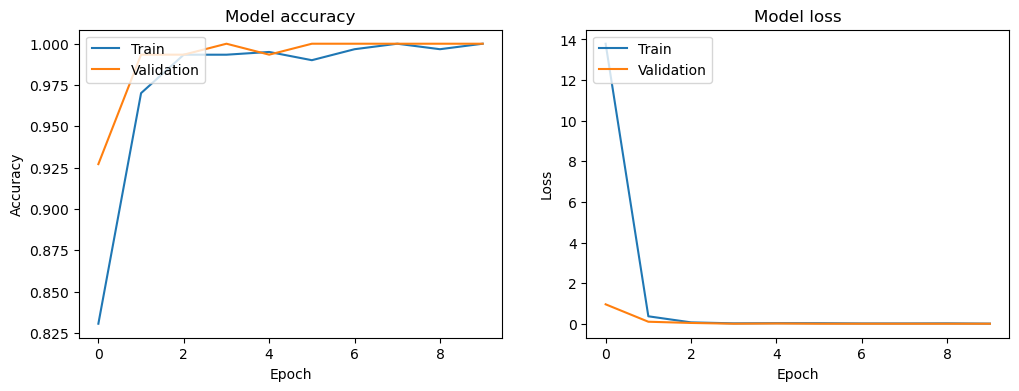

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step


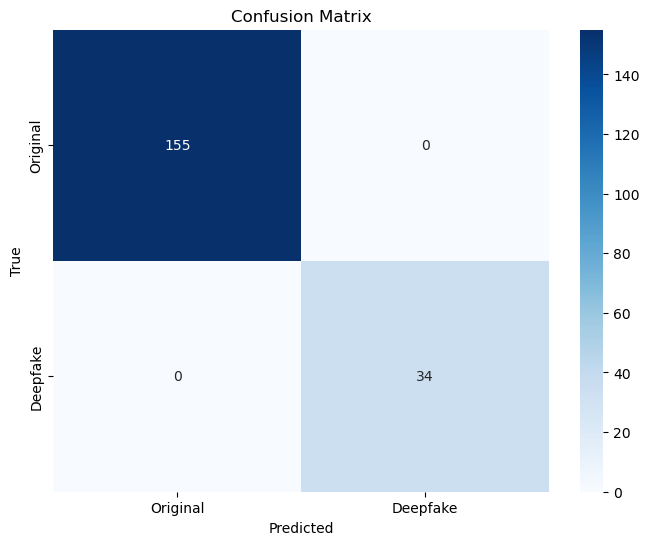

              precision    recall  f1-score   support

    Original       1.00      1.00      1.00       155
    Deepfake       1.00      1.00      1.00        34

    accuracy                           1.00       189
   macro avg       1.00      1.00      1.00       189
weighted avg       1.00      1.00      1.00       189



In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

# Function to load images from a folder and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=(224, 224))  # Resize images to match VGG16 input size
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'


# Load images
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
X = np.array(deepfake_images + original_images)
y = np.array(deepfake_labels + original_labels)

# Preprocess the images
X = preprocess_input(X)

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the pre-trained VGG16 model with the top layers removed
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 layers to prevent them from being trained
vgg_model.trainable = False

# Add custom classification layers on top of VGG16
x = vgg_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularization
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=vgg_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['Original', 'Deepfake']))


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
# Load pre-trained VGG16 model and modify for binary classification
from torchvision.models import vgg16, VGG16_Weights

# Custom dataset class for loading images
class SpectrogramDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Function to load images and assign labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((224, 224))  # Resize images to match VGG16 input size
            images.append(img)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images and labels
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
images = np.array(deepfake_images + original_images)
labels = np.array(deepfake_labels + original_labels)

# Convert labels to tensor
labels = torch.tensor(labels)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG16 preprocessing
])

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = SpectrogramDataset(train_images, train_labels, transform=transform)
test_dataset = SpectrogramDataset(test_images, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained VGG16 model with the updated 'weights' argument
vgg_model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

#vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, 2)  # Modify the last layer for binary classification

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16 = vgg16.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# Evaluating the model
vgg16.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Original', 'Deepfake']))

# Function to register hooks for intermediate layers
def register_hooks(model, layer_names):
    activations = {}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    hooks = []
    for name in layer_names:
        layer = dict(model.named_children()).get(name)
        if layer is not None:
            hooks.append(layer.register_forward_hook(get_activation(name)))
    return activations, hooks

# Get sample image from the test set
sample_image = test_images[0]
sample_image = transform(sample_image).unsqueeze(0).to(device)

# Register hooks to capture activations from selected layers
activations, hooks = register_hooks(vgg16.features, ['0', '5', '10', '17', '24'])  # Corresponding to some conv layers

# Pass the sample image through the model to capture activations
vgg16.eval()
with torch.no_grad():
    _ = vgg16(sample_image)

# Remove hooks
for hook in hooks:
    hook.remove()

# Visualize the activations
fig, axes = plt.subplots(5, 8, figsize=(20, 20))  # Visualize 8 channels from 5 layers
for layer_index, layer_name in enumerate(['0', '5', '10', '17', '24']):
    activation = activations[layer_name]
    num_channels = activation.shape[1]
    for channel_index in range(8):  # Visualize the first 8 channels
        ax = axes[layer_index, channel_index]
        ax.imshow(activation[0, channel_index].cpu().numpy(), cmap='viridis')
        ax.axis('off')

plt.show()


Epoch [1/10], Loss: 0.5086, Accuracy: 75.70%
Epoch [2/10], Loss: 0.1406, Accuracy: 96.02%
Epoch [3/10], Loss: 0.0353, Accuracy: 98.54%
Epoch [4/10], Loss: 0.0157, Accuracy: 99.20%
Epoch [5/10], Loss: 0.0015, Accuracy: 100.00%
Epoch [6/10], Loss: 0.0006, Accuracy: 100.00%
Epoch [7/10], Loss: 0.0004, Accuracy: 100.00%
Epoch [8/10], Loss: 0.0003, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0003, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0002, Accuracy: 100.00%
Test Accuracy: 100.00%


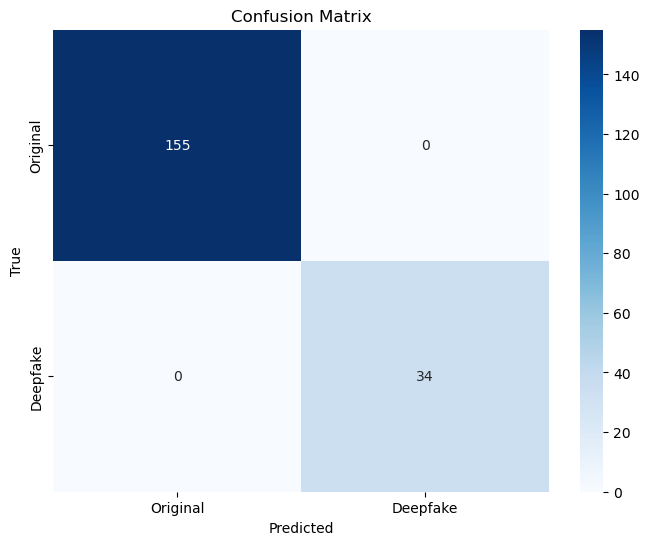

              precision    recall  f1-score   support

    Original       1.00      1.00      1.00       155
    Deepfake       1.00      1.00      1.00        34

    accuracy                           1.00       189
   macro avg       1.00      1.00      1.00       189
weighted avg       1.00      1.00      1.00       189

Activation images saved in activation_images


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define the CNN model
class SpectraCNN(nn.Module):
    def __init__(self):
        super(SpectraCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Custom dataset class for loading images
class SpectrogramDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Function to load images and assign labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((128, 128))  # Resize images for consistency
            images.append(img)
            labels.append(label)
    return images, labels

# Paths to spectrogram folders
deepfake_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/ElevenLabs_Images'
original_folder = '/Users/aishwaryadekhane/Desktop/My_Files/RA/Spectrogram/Barack_Obama/Original_Images'

# Load images and labels
deepfake_images, deepfake_labels = load_images_from_folder(deepfake_folder, label=1)
original_images, original_labels = load_images_from_folder(original_folder, label=0)

# Combine and create dataset
images = np.array(deepfake_images + original_images)
labels = np.array(deepfake_labels + original_labels)

# Convert labels to tensor
labels = torch.tensor(labels)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = SpectrogramDataset(train_images, train_labels, transform=transform)
test_dataset = SpectrogramDataset(test_images, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpectraCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# Evaluating the model
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Deepfake'], yticklabels=['Original', 'Deepfake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Original', 'Deepfake']))

# Function to register hooks for intermediate layers
def register_hooks(model, layer_names):
    activations = {}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    hooks = []
    for name in layer_names:
        layer = model._modules.get(name)
        if layer is not None:
            hooks.append(layer.register_forward_hook(get_activation(name)))
    return activations, hooks

# Ensure directory for saving activation images exists
activation_dir = "activation_images"
os.makedirs(activation_dir, exist_ok=True)

# Get sample image from the test set
sample_image = test_images[0]
sample_image = transform(sample_image).unsqueeze(0).to(device)

# Register hooks to capture activations
activations, hooks = register_hooks(model, ['conv1', 'conv2', 'conv3'])

# Pass the sample image through the model to capture activations
model.eval()
with torch.no_grad():
    _ = model(sample_image)

# Remove hooks
for hook in hooks:
    hook.remove()

# Save the activations to disk
for layer_name in ['conv1', 'conv2', 'conv3']:
    activation = activations[layer_name]
    num_channels = activation.shape[1]
    layer_dir = os.path.join(activation_dir, layer_name)
    os.makedirs(layer_dir, exist_ok=True)
    
    for channel_index in range(num_channels):
        activation_map = activation[0, channel_index].cpu().numpy()
        plt.imshow(activation_map, cmap='viridis')
        plt.axis('off')
        
        # Save the figure
        file_path = os.path.join(layer_dir, f"activation_{channel_index}.jpg")
        plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
        plt.close()

print(f'Activation images saved in {activation_dir}')